In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob

labels_df = pd.read_csv(r"C:\Users\sai12\71215_152137_bundle_archive\labels.csv")
labels = np.array(labels_df[' hemorrhage'].tolist())

In [15]:
files = sorted(glob.glob(r"C:\Users\sai12\71215_152137_bundle_archive\head_ct\head_ct/*.png"))

In [16]:
images = np.array([cv2.imread(path) for path in files])

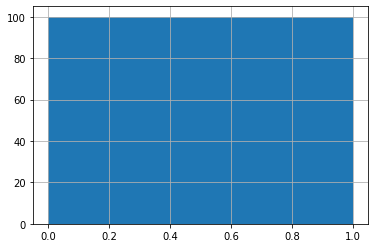

In [17]:
labels_df[' hemorrhage'].hist(bins=2)

In [18]:
images_df = pd.DataFrame(images, columns=['image'])

In [19]:
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])

In [20]:
images_df[['height', 'width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


In [21]:
images = np.array([cv2.resize(image, (128, 128)) for image in images])


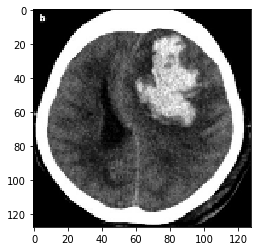

In [22]:
plt.imshow(images[0])

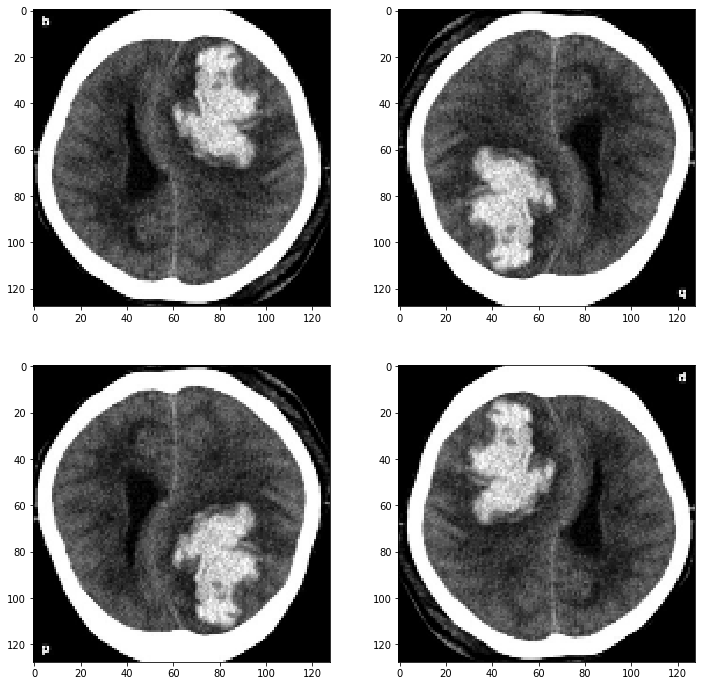

In [23]:
plt.figure(figsize=(12, 12))
for i, flip in enumerate([None, -1, 0, 1]):
    plt.subplot(221 + i)
    if flip is None:
        plt.imshow(images[0])
    else:
        plt.imshow(cv2.flip(images[0], flip))


In [24]:
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
indicies = np.random.permutation(100)
train_true_idx, test_true_idx = indicies[:90], indicies[90:]
train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100
train_idx, test_idx = np.append(train_true_idx, train_false_idx), np.append(test_true_idx, test_false_idx)

train_validationX, train_validationY = images[train_idx], labels[train_idx]
testX, testY = images[test_idx], labels[test_idx]

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [26]:
tr_len = train_validationX.shape[0]
train_val_split = int(tr_len*0.9)
indicies = np.random.permutation(tr_len)
train_idx, validation_idx = indicies[:train_val_split], indicies[train_val_split:]

trainX, trainY = train_validationX[train_idx], train_validationY[train_idx]
validationX, validationY = train_validationX[validation_idx], train_validationY[validation_idx]

print(trainX.shape, validationX.shape)
print(trainY.shape, validationY.shape)

(162, 128, 128, 3) (18, 128, 128, 3)
(162,) (18,)


In [48]:
import tensorflow as tf
import tensorflow.python.keras 

In [54]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import math

In [55]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

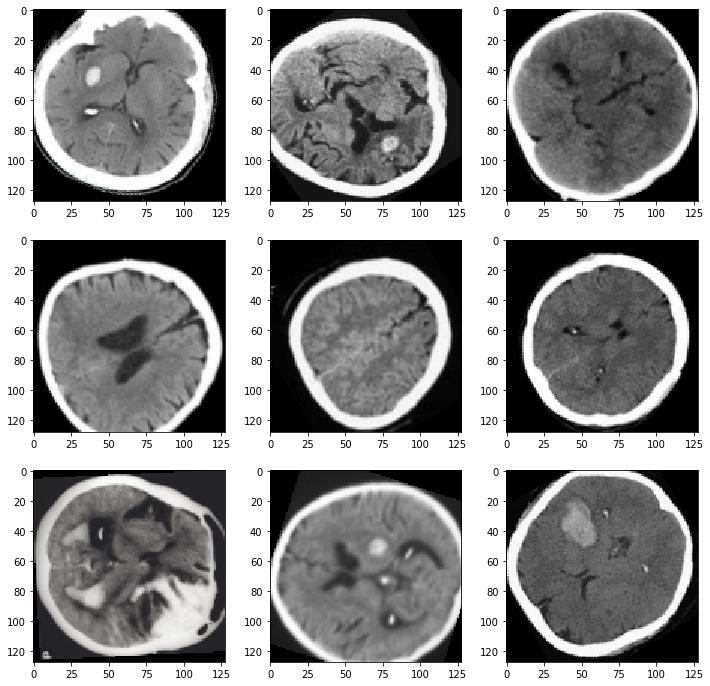

In [56]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

In [57]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [58]:
def simple_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [59]:
model = simple_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [61]:
model.fit_generator(train_image_data.flow(trainX, trainY, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=16)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/16
128/128 [==============================] - ETA: 0s - batch: 63.5000 - size: 81.0000 - loss: 0.6777 - acc: 0.5506WARNING:tensorflow:From C:\Users\sai12\Anaconda3\New folder\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2044: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
128/128 [==============================] - 49s 381ms/step - batch: 63.5000 - size: 81.0000 - loss: 0.6777 - acc: 0.5506 - val_loss: 0.6455 - val_acc: 0.6333
Epoch 2/16
128/128 [==============================] - 50s 388ms/step - batch: 63.5000 - size: 81.0000 - loss: 0.6090 - acc: 0.6733 - val_loss: 0.6656 - val_acc: 0.6089
Epoch 3/16
128/128 [==============================] - 50s 393ms/step - batch: 63.5000 - size: 81.0000 - los

True positive: 8 , True negative: 9 , False positive: 1 , False negative: 0
Total accuracy: 94.44444444444444 %


(9, 1, 0, 8)

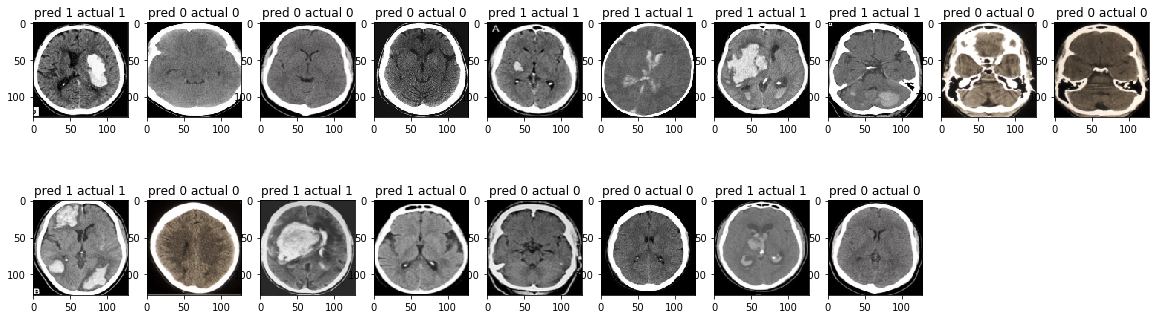

In [62]:
check_accuracy(model, validationX/255., validationY)

In [63]:
model.save("last-weights.h5")
model.load_weights("weights.h5")

In [64]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 77 , True negative: 68 , False positive: 12 , False negative: 5
Total accuracy: 89.50617283950618 %


(68, 12, 5, 77)

True positive: 8 , True negative: 9 , False positive: 1 , False negative: 0
Total accuracy: 94.44444444444444 %


(9, 1, 0, 8)

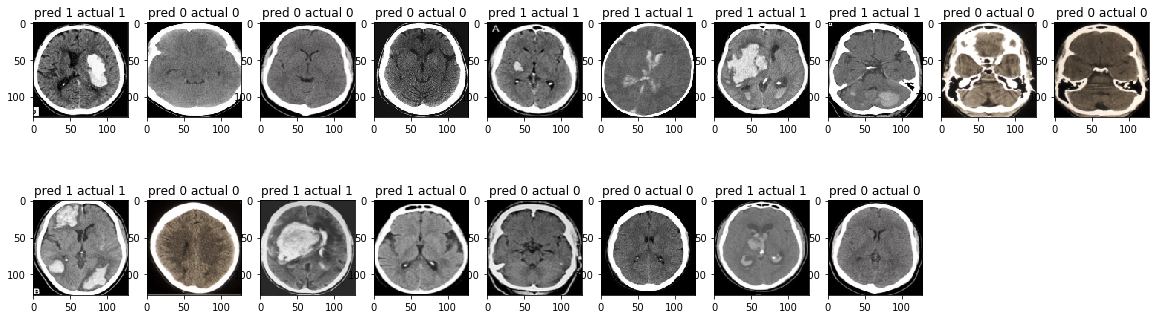

In [65]:
check_accuracy(model, validationX/255., validationY)

In [66]:
def imbalance_set(coeff=2):
    imbalanced_trainX = []
    imbalanced_trainY = []
    for i, train_x in enumerate(trainX):
        def add_entry(x, y):
            imbalanced_trainX.append(x)
            imbalanced_trainY.append(y)

        add_entry(train_x, trainY[i])

        if(trainY[i] == 1):
            for j in range(coeff-1):
                add_entry(train_x, trainY[i])
    return (np.array(imbalanced_trainX), np.array(imbalanced_trainY))

imbalanced_trainX, imbalanced_trainY = imbalance_set(2)
print(imbalanced_trainX.shape, imbalanced_trainY.shape)

(244, 128, 128, 3) (244,)


In [67]:
def bigger_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [68]:
model = bigger_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [69]:
model.fit_generator(train_image_data.flow(imbalanced_trainX, imbalanced_trainY, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("bigger_model_checkpoint_weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=24)


Epoch 1/24
128/128 [==============================] - 72s 560ms/step - batch: 63.5000 - size: 122.0000 - loss: 0.6062 - acc: 0.6767 - val_loss: 0.6737 - val_acc: 0.5467
Epoch 2/24
128/128 [==============================] - 71s 554ms/step - batch: 63.5000 - size: 122.0000 - loss: 0.5338 - acc: 0.7382 - val_loss: 0.6144 - val_acc: 0.6578
Epoch 3/24
128/128 [==============================] - 71s 558ms/step - batch: 63.5000 - size: 122.0000 - loss: 0.4990 - acc: 0.7590 - val_loss: 0.5111 - val_acc: 0.6922
Epoch 4/24
128/128 [==============================] - 76s 592ms/step - batch: 63.5000 - size: 122.0000 - loss: 0.4731 - acc: 0.7752 - val_loss: 0.4995 - val_acc: 0.7100
Epoch 5/24
128/128 [==============================] - 73s 572ms/step - batch: 63.5000 - size: 122.0000 - loss: 0.4463 - acc: 0.7918 - val_loss: 0.6002 - val_acc: 0.6344
Epoch 6/24
128/128 [==============================] - 75s 583ms/step - batch: 63.5000 - size: 122.0000 - loss: 0.4295 - acc: 0.8017 - val_loss: 0.4594 - va

In [70]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 82 , True negative: 72 , False positive: 8 , False negative: 0
Total accuracy: 95.06172839506173 %


(72, 8, 0, 82)

In [71]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 8 , True negative: 9 , False positive: 1 , False negative: 0
Total accuracy: 94.44444444444444 %


(9, 1, 0, 8)

In [72]:
model.save("bigger_model_latest_weights.h5")
model.load_weights("bigger_model_checkpoint_weights.h5")

In [73]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 80 , True negative: 76 , False positive: 4 , False negative: 2
Total accuracy: 96.29629629629629 %


(76, 4, 2, 80)

True positive: 8 , True negative: 9 , False positive: 1 , False negative: 2
Total accuracy: 85.0 %


(9, 1, 2, 8)

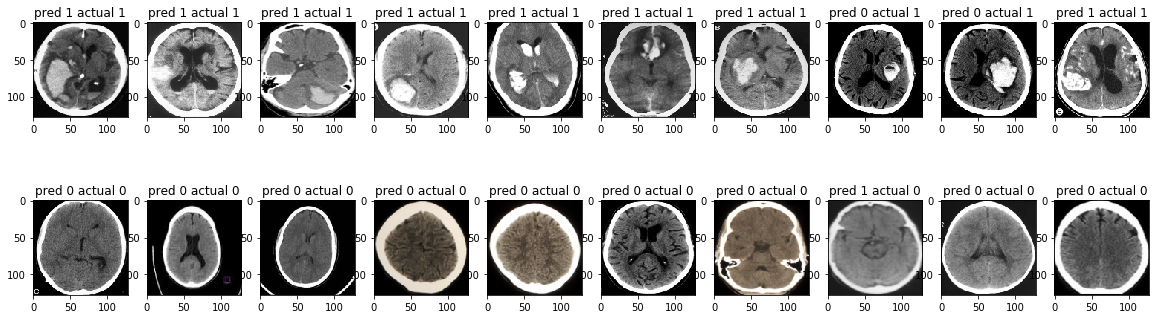

In [74]:
check_accuracy(model, testX/255., testY)